## MNIST를 통한 단순 CNN구현

#### 라이브러리 로드, 그래프 세션 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
sess = tf.Session()

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### 데이터로드, 이미지를 28x28로 변환

In [2]:
data_dir = 'cnn_mnist_temp'
mnist = read_data_sets(data_dir)
#train 
train_xdata = np.array([np.reshape(x,(28,28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])
#test
train_labels = mnist.train.labels
test_labels = mnist.test.labels

Extracting cnn_mnist_temp/train-images-idx3-ubyte.gz
Extracting cnn_mnist_temp/train-labels-idx1-ubyte.gz
Extracting cnn_mnist_temp/t10k-images-idx3-ubyte.gz
Extracting cnn_mnist_temp/t10k-labels-idx1-ubyte.gz


#### 매개변수 설정

In [3]:
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = train_xdata[0].shape[0]
image_height = train_xdata[0].shape[1]
target_size = max(train_labels) + 1
num_channels =1
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2
max_pool_size2 = 2
fully_connected_size1 = 100

#### 플레이스홀더 선언

In [4]:
x_input_shape = (batch_size, image_width, image_height, num_channels)
x_input = tf.placeholder(tf.float32, shape = x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
eval_input = tf.placeholder(tf.float32, shape = eval_input_shape)
eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))

#### weight, bias

In [5]:
# Convolutional layer variables
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features],stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

In [6]:
resulting_width = image_width // (max_pool_size1 * max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1],stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size],stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

#### 모델 선언 

In [7]:
def my_conv_net(input_data):
    #첫번째 합성곱 - Relu - 맥스풀 계층
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1,1,1,1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_poll1 = tf.nn.max_pool(relu1, ksize=[1,max_pool_size1,max_pool_size1,1], strides=[1,max_pool_size1,max_pool_size1,1], padding='SAME')
    
    #두번째 합성곱 - Relu - 맥스풀 계층
    conv2 = tf.nn.conv2d(max_poll1, conv2_weight, strides=[1,1,1,1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_poll2 = tf.nn.max_pool(relu2, ksize=[1,max_pool_size2,max_pool_size2,1], strides=[1,max_pool_size2,max_pool_size2,1], padding='SAME')
    
    #이어지는 완전 연결 계층을 위해 출력을 1xN으로 변환
    final_conv_shape = max_poll2.get_shape().as_list()
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_poll2, [final_conv_shape[0], final_shape])
    
    #첫번째 완전 연결 계층
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    
    #두번째 완전 연결 계층
    final_model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    
    return(final_model_output)

#### 학습데이터 및 테스트데이터 모델 선언

In [8]:
model_output = my_conv_net(x_input)
test_model_output = my_conv_net(eval_input)

#### softmax함수 사용
여러분류가 아닌 한가지 분류만 대상으로 하므로 softmax사용

In [9]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

#### 예측함수 생성, 정확도 함수

In [10]:
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)

def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return (100*num_correct/batch_predictions.shape[0])

#### 최적화 함수 생성, 모델변수 초기화

In [11]:
my_optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = my_optimizer.minimize(loss)

sess.run(tf.global_variables_initializer())

In [12]:
train_loss = []
train_acc = []
test_acc = []
for i in range(generations):
    rand_index = np.random.choice(len(train_xdata), size=batch_size)
    rand_x = train_xdata[rand_index]ㅐ
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_labels[rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if (i+1) % eval_every == 0:
        eval_index = np.random.choice(len(test_xdata), size=evaluation_size)
        eval_x = test_xdata[eval_index]
        eval_x = np.expand_dims(eval_x, 3)
        eval_y = test_labels[eval_index]
        test_dict = {eval_input: eval_x, eval_target: eval_y}
        test_preds = sess.run(test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(test_preds, eval_y)
        
        # Record and print results
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 5. Train Loss: 1.54. Train Acc (Test Acc): 67.00 (60.60)
Generation # 10. Train Loss: 0.63. Train Acc (Test Acc): 85.00 (76.40)
Generation # 15. Train Loss: 0.37. Train Acc (Test Acc): 88.00 (85.60)
Generation # 20. Train Loss: 0.23. Train Acc (Test Acc): 91.00 (86.60)
Generation # 25. Train Loss: 0.27. Train Acc (Test Acc): 94.00 (90.40)
Generation # 30. Train Loss: 0.30. Train Acc (Test Acc): 93.00 (89.60)
Generation # 35. Train Loss: 0.17. Train Acc (Test Acc): 95.00 (92.80)
Generation # 40. Train Loss: 0.27. Train Acc (Test Acc): 94.00 (93.00)
Generation # 45. Train Loss: 0.23. Train Acc (Test Acc): 96.00 (95.20)
Generation # 50. Train Loss: 0.21. Train Acc (Test Acc): 91.00 (94.40)
Generation # 55. Train Loss: 0.09. Train Acc (Test Acc): 97.00 (95.40)
Generation # 60. Train Loss: 0.18. Train Acc (Test Acc): 91.00 (96.60)
Generation # 65. Train Loss: 0.16. Train Acc (Test Acc): 94.00 (96.00)
Generation # 70. Train Loss: 0.11. Train Acc (Test Acc): 97.00 (93.80)
Generat

#### loss acc 그래프

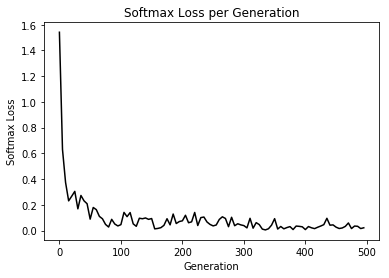

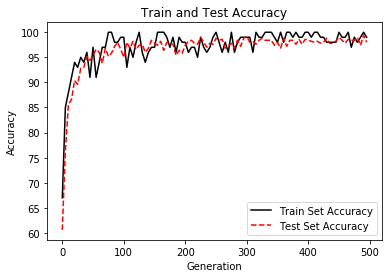

In [13]:
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
# Plot loss over time
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot train and test accuracy
plt.plot(eval_indices, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

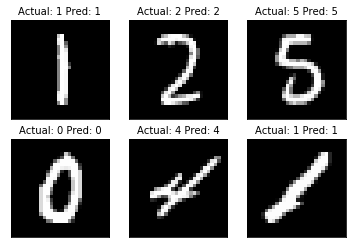

In [14]:
# Plot some samples
# Plot the 6 of the last batch results:
actuals = rand_y[0:6]
predictions = np.argmax(temp_train_preds,axis=1)[0:6]
images = np.squeeze(rand_x[0:6])

Nrows = 2
Ncols = 3
for i in range(6):
    plt.subplot(Nrows, Ncols, i+1)
    plt.imshow(np.reshape(images[i], [28,28]), cmap='Greys_r')
    plt.title('Actual: ' + str(actuals[i]) + ' Pred: ' + str(predictions[i]),
                               fontsize=10)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()